# Project: 멋진 챗봇 만들기

**루브릭**
<img width="630" alt="image" src="https://github.com/user-attachments/assets/0f8bf706-f619-429c-a9b4-21b4fb261aa6" />

# 0. 필요 라이브러리 로드

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import re
import nltk
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 1. 데이터 다운로드 

In [3]:
data_url = "https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv"
data = pd.read_csv(data_url)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [5]:
questions = pd.DataFrame(data['Q'])
answers = pd.DataFrame(data['A'])

len(questions), len(answers)

(11823, 11823)

# 2. 데이터 정제 및 토큰화

In [6]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-zA-Z0-9가-힣?.!,]+", " ", sentence)
    return sentence

In [7]:
# KoNLPY mecab 사용
from konlpy.tag import Mecab

-----------------------------------
Questions Dataset
Min:  1
Max:  32
Avg:  7.020045673686882

Answers Dataset
Min:  1
Max:  40
Avg:  8.376554174067495
-----------------------------------


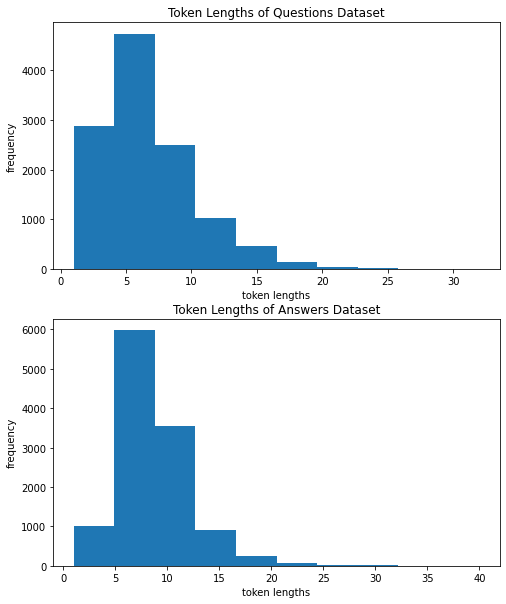

In [8]:
# 토큰 길이 분포 확인하기
mecab = Mecab()
src_tokenized = [mecab.morphs(preprocess_sentence(sent)) for sent in questions['Q']]
tgt_tokenized = [mecab.morphs(preprocess_sentence(sent)) for sent in answers['A']]

src_token_len = [len(tokens) for tokens in src_tokenized]
tgt_token_len = [len(tokens) for tokens in tgt_tokenized]

print("-----------------------------------")
print("Questions Dataset")
print("Min: ", np.min(src_token_len))
print("Max: ", np.max(src_token_len))
print("Avg: ", np.average(src_token_len))

print("\nAnswers Dataset")
print("Min: ", np.min(tgt_token_len))
print("Max: ", np.max(tgt_token_len))
print("Avg: ", np.average(tgt_token_len))
print("-----------------------------------")

plt.figure(figsize = (8, 10))
plt.subplot(211)
plt.hist(src_token_len)
plt.xlabel("token lengths")
plt.ylabel("frequency")
plt.title("Token Lengths of Questions Dataset")   

plt.subplot(212)
plt.hist(tgt_token_len)
plt.xlabel("token lengths")
plt.ylabel("frequency")
plt.title("Token Lengths of Answers Dataset")   

plt.show()
    

In [9]:
for length, tokens in zip(src_token_len, src_tokenized):
    if length == 1:
        print(tokens)

['건방져']
['겁난다']
['굿모닝']
['단수']
['더워']
['무서워요']
['미워']
['미워한다']
['반가워']
['반가워']
['배고파']
['배고파']
['배불러']
['배불러']
['비트코인']
['속상해']
['스트레스']
['아파']
['안녕']
['야']
['어머']
['어머나']
['에이씨']
['오지마']
['외로워']
['외로워']
['으악']
['음']
['응']
['이놈']
['잘래']
['저기']
['조심조심']
['졸려']
['추워']
['코자']
['콜록콜록']
['허기져']
['헉']
['괴로워']
['그리움']
['기다림']
['꿈']
['나그네']
['넋두리']
['눈물']
['답답증']
['덤덤']
['뜬금없이']
['마무리']
['멘붕']
['무상']
['무제']
['미련']
['미쳐']
['바람']
['받아들여야지']
['변명']
['분노']
['불면증']
['사진첩']
['살아간다']
['상념']
['상처']
['새벽']
['술주정']
['시련']
['심심']
['싱숭생숭']
['쓰레기']
['씁쓸']
['아파']
['야']
['양다리']
['어째서']
['에휴']
['연휴']
['왜']
['외로움']
['외로워']
['외로워']
['외로워서']
['으흠']
['이별']
['이혼']
['인내']
['인연']
['자괴감']
['잠수']
['젠장']
['주저리주저리']
['증오']
['지친다']
['짝사랑']
['착각']
['첫눈']
['최악']
['침묵']
['통증']
['파혼']
['핑계']
['한숨']
['헤어짐']
['헤어짐']
['혼자']
['후']
['후우']
['후회']
['휴']
['흔적']
['흠']
['고백']


In [10]:
for length, tokens in zip(tgt_token_len, tgt_tokenized):
    if length == 1:
        print(tokens)

['킁킁']
['킁킁']
['킁킁']
['꼬르륵']
['꼬르륵']
['네']
['킁킁']
['음']
['네']
['음']
['토닥토닥']
['사랑']
['네']
['네']
['아이구']
['휴우']
['어머나']


- 토큰 개수가 1개인 Question, Answer 출력했을 때, 노이즈가 많이 섞여있는 듯 함...
- 일단은 다 포함하는 것으로... 
- max_len 값도 우선 40까지 모두 포함하기로 함

In [11]:
# 데이터 토큰화, 중복데이터 제거 

def build_corpus(src_data, tgt_data):
    
    # 텍스트 전처리
    src_data['Q'] = src_data['Q'].apply(preprocess_sentence)
    tgt_data['A'] = tgt_data['A'].apply(preprocess_sentence)
    
    # 중복 Index 확인
    dup_index = []
    src_dup_idx = [idx for idx in src_data[src_data['Q'].duplicated()].index]
    print("len of src_dup_idx: ", len(src_dup_idx))
    tgt_dup_idx = [idx for idx in tgt_data[tgt_data['A'].duplicated()].index]
    print("len of tgt_dup_idx: ", len(tgt_dup_idx))
    src_dup_idx.extend(tgt_dup_idx)
    dup_idx = list(set(src_dup_idx))
    print("len of dup_idx: ", len(dup_idx))
    print("--------------------------------------")
    
    # 중복 데이터 제거
    filtered_src_data = src_data.drop(index = dup_idx)
    filtered_tgt_data = tgt_data.drop(index = dup_idx)
    print("Original src_data length: ", len(src_data))
    print("Filtered src_data length: ", len(filtered_src_data))
    print("Original tgt_data length: ", len(tgt_data))
    print("Filtered tgt_data length: ", len(filtered_tgt_data))
    
    # 토큰화
    src_tokenized = [mecab.morphs(sent) for sent in filtered_src_data['Q']]
    tgt_tokenized = [mecab.morphs(sent) for sent in filtered_tgt_data['A']]
    
    return src_tokenized, tgt_tokenized

In [12]:
que_corpus, ans_corpus = build_corpus(questions, answers)

len of src_dup_idx:  161
len of tgt_dup_idx:  4044
len of dup_idx:  4111
--------------------------------------
Original src_data length:  11823
Filtered src_data length:  7712
Original tgt_data length:  11823
Filtered tgt_data length:  7712


# 3. Augmentation 

In [1]:
# gensim 버전 문제 발생 4.x -> 3.x 버전으로 다운그레이드
!pip install gensim==3.8.3

     |████████████████████████████████| 23.4 MB 4.2 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=24328218 sha256=9694ba4443647649782bfaa5cbff3cb041af1a300ac2e13ba2385c9f2442cb92
  Stored in directory: /aiffel/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2


In [13]:
import gensim

model_path = "ko.bin"
ko_model = gensim.models.Word2Vec.load(model_path)
ko_model.wv.most_similar("강아지")

[('고양이', 0.7290452718734741),
 ('거위', 0.7185635566711426),
 ('토끼', 0.7056223154067993),
 ('멧돼지', 0.6950401067733765),
 ('엄마', 0.6934334635734558),
 ('난쟁이', 0.6806551218032837),
 ('한마리', 0.6770296096801758),
 ('아가씨', 0.6750352382659912),
 ('아빠', 0.6729634404182434),
 ('목걸이', 0.6512460708618164)]

In [14]:
def lexical_sub(aug_tokens, ko_model):
    
    # 숫자가 선택되는 경우 에러 발생하여 한글만 선택하도록 설정
    candidate_tokens = [tok for tok in aug_tokens if re.match(r"^[가-힣]+$", tok)]
    if not candidate_tokens:
        return aug_tokens
    
    selected_tok = random.choice(candidate_tokens)
    
    result = []
    for tok in aug_tokens:
        if tok is selected_tok:
            try:
                
                result.append(ko_model.wv.most_similar(tok)[0][0])
            except KeyError:
                result.append(tok)
        else:
            result.append(tok)
    
    return result

In [15]:
def corpus_augmentation(que_corpus, ans_corpus, ko_model):
    que_corpus_result = []
    ans_corpus_result = []
    
    # ans_corpus augmenation
    ans_corpus_aug = [lexical_sub(tokens, ko_model) for tokens in ans_corpus]
    
    # que_corpus augmentation
    que_corpus_aug = [lexical_sub(tokens, ko_model) for tokens in que_corpus]
    
    # consolidate augmentation results
    que_corpus_result = que_corpus + que_corpus + que_corpus_aug
    ans_corpus_result = ans_corpus + ans_corpus_aug + ans_corpus
    
    return que_corpus_result, ans_corpus_result    

In [16]:
que_corpus, ans_corpus = corpus_augmentation(que_corpus, ans_corpus, ko_model)
print(len(que_corpus), len(ans_corpus))

23136 23136


# 4. 데이터 벡터화 

In [17]:
def add_start_end_tokens(tokens):
    return ['<start>'] + tokens + ["<end>"]

ans_corpus = [add_start_end_tokens(tokens) for tokens in ans_corpus]
ans_corpus[:5]

[['<start>', '하루', '가', '또', '가', '네요', '.', '<end>'],
 ['<start>', '위로', '해', '드립니다', '.', '<end>'],
 ['<start>', '여행', '은', '언제나', '좋', '죠', '.', '<end>'],
 ['<start>', '눈살', '이', '찌푸려', '지', '죠', '.', '<end>'],
 ['<start>', '다시', '새로', '사', '는', '게', '마음', '편해요', '.', '<end>']]

In [18]:
from keras.preprocessing.text import Tokenizer

vocab_size = 20000

# tokenizer 생성
tokenizer = Tokenizer(num_words = vocab_size, oov_token = "<unk>")
tokenizer.fit_on_texts(que_corpus + ans_corpus)

# 정수 인코딩
que_corpus_encoded = tokenizer.texts_to_sequences(que_corpus)
ans_corpus_encoded = tokenizer.texts_to_sequences(ans_corpus)

print(que_corpus_encoded[0])
print(ans_corpus_encoded[0])

[2204, 218, 3605, 108]
[3, 282, 9, 142, 9, 42, 2, 4]


In [19]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [20]:
# 패딩 처리하기
from keras.preprocessing.sequence import pad_sequences
max_len = 40
enc_train = pad_sequences(que_corpus_encoded, maxlen = max_len, padding = "post", value = 0)
dec_train = pad_sequences(ans_corpus_encoded, maxlen = max_len, padding = "post", value = 0)

In [21]:
# 배치 나누기
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).batch(batch_size = BATCH_SIZE)

# 5. 훈련하기 

In [62]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [63]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_lookahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)

    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_tgt_padding_mask = generate_padding_mask(tgt)
    dec_mask = tf.maximum(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [64]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x

    
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
                        
        out = self.combine_heads(out)
        out = self.linear(out)
            
        return out, attention_weights

In [65]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
            
        return out

In [66]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [67]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        '''
        Masked Multi-Head Attention
        '''
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        '''
        Multi-Head Attention
        '''
        residual = out
        out = self.norm_2(out)
        # Q, K, V 순서에 주의하세요!
        out, dec_enc_attn = self.enc_dec_attn(Q=out, K=enc_out, V=enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out += residual
        
        '''
        Position-Wise Feed Forward Network
        '''
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn


In [68]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [69]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
    def call(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [70]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        
        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, dec_enc_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [71]:
# 하이퍼 파라미터
n_layers = 6
d_model = 256
n_heads = 8
d_ff = 1024
pos_len = max_len
dropout = 0.1

In [72]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=n_layers,
    d_model=d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    pos_len=max_len,
    dropout=0.1,
    shared_fc=True,
    shared_emb=True)

In [73]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [74]:

learning_rate = LearningRateScheduler(d_model = 512)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [75]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [76]:
# Train Step 정의
#@tf.function()
def train_step(src, tgt, model, optimizer):
    # TODO: 구현    
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [77]:
def generate_response(sentence, model, tokenizer):
    sentence = preprocess_sentence(sentence)
    pieces = mecab.morphs(sentence)
    tokens = tokenizer.texts_to_sequences(pieces)
    
    _input = pad_sequences(tokens, maxlen = enc_train.shape[-1], padding = 'post', value = 0)
    
    ids = []
    output = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
            generate_masks(_input, output)
        
        predictions, _, _, _ = model(_input, 
                                     output,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        
        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis = -1)[0, -1]).numpy().item()
        
        if tokenizer.word_index['<end>'] == predicted_id:
            result = [tokenizer.index_word[idx] for idx in ids]
            result = " ".join(result)
            return result
        
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis = -1)
        
    result = " ".join([tokenizer.index_word[idx] for idx in ids])
    return result
        

In [78]:
sample_text = [
    '지루하다, 놀러가고 싶어.',
    '오늘 일찍 일어났더니 피곤하다.',
    '간만에 여자친구랑 데이트 하기로 했어.',
    '집에 있는다는 소리야.'
]

In [79]:
EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0
    
    dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
    tqdm_bar = tqdm(enumerate(train_dataset), total=dataset_count, desc = f"EPOCH {epoch+1}")

    for batch, (src, tgt) in tqdm_bar:
        loss, enc_attns, dec_attns, dec_enc_attns = train_step(src, tgt, transformer, optimizer)
        total_loss += loss.numpy()

        tqdm_bar.set_postfix({
            "Batch": batch + 1,
            "Loss": loss.numpy(),
            "Avg Loss": total_loss / (batch + 1)
        })
    
    tqdm_bar.close()
    
    print("Generated Responses")   
    for idx, text in enumerate(sample_text):
        
        result = \
        generate_response(text, transformer, tokenizer)
        
        print(f"> input : {idx+1}. {text}")
        print(f"> output: {idx+1}. {result}")
        
    print("\nHyperparameters")
    print("n_layers: ", n_layers)
    print("d_model: ", d_model)
    print("n_heads: ", n_heads)
    print("d_ff: ", d_ff)
    print("dropout: ", dropout)
        
    print("\nTraining Parameters")
    print("Warmup Steps: ", learning_rate.warmup_steps)
    print("Batch Size: ", BATCH_SIZE)
    print("Epoch At: ", epoch+1)
    print("-------------------------------------------")
    
    
    print(f"Epoch {epoch + 1} completed. Average Loss: {total_loss / dataset_count:.4f}")

EPOCH 1: 100%|██████████| 362/362 [02:00<00:00,  3.01it/s, Batch=362, Loss=4.78, Avg Loss=6.24]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 은 은 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 게 .
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 좋 좋 좋 좋 게 좋 좋 좋 좋 좋 좋 좋 좋 좋 좋 좋 좋 좋 좋 .
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 사랑 는 는 게 는 는 는 는 는 는 게 는 는 는 는 게 게 게 게 게 는 는 는 는 보 세요 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 좋 좋 좋 좋 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  1
-------------------------------------------
Epoch 1 completed. Average Loss: 6.2412


EPOCH 2: 100%|██████████| 362/362 [02:00<00:00,  3.01it/s, Batch=362, Loss=3.66, Avg Loss=4.09]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 연락 이 연락 이 연락 이
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 좋 은 좋 은 좋 아 하 세요 .
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 사랑 이 도 응원 할 수 도 있 어요 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 좋 은 좋 은 좋 은 좋 은 좋 은 좋 은 좋 은 좋 은 좋 은 좋 은 좋 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  2
-------------------------------------------
Epoch 2 completed. Average Loss: 4.0890


EPOCH 3: 100%|██████████| 362/362 [01:58<00:00,  3.05it/s, Batch=362, Loss=2.81, Avg Loss=3.16]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 그 사람 은 그 사람 이 요 .
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 오늘 았 길 바랄게요 .
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 꼬시 가 가 대로 응원 해 보 세요 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 좋 은 사람 이 최고 길 바랄게요 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  3
-------------------------------------------
Epoch 3 completed. Average Loss: 3.1603


EPOCH 4: 100%|██████████| 362/362 [01:58<00:00,  3.05it/s, Batch=362, Loss=2.14, Avg Loss=2.39]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 그 사람 으로 연락 하 는 게 좋 아 보 세요 .
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 오늘 랑 안녕 !
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 사랑 도 사랑 도 사랑 도 몰랐 도 좋 아요 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 무작정 할 수 없 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  4
-------------------------------------------
Epoch 4 completed. Average Loss: 2.3851


EPOCH 5: 100%|██████████| 362/362 [02:16<00:00,  2.65it/s, Batch=362, Loss=1.31, Avg Loss=1.74]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 내 연락 이 내 말 이 내 내 요 .
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 안녕 을 전해 보 세요 .
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 별거 도 주 주 주 세요 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 참 이 면 좋 으면 좋 으면 좋 으면 좋 으면 좋 으면 좋 은 것 같 은 것 같 습니다 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  5
-------------------------------------------
Epoch 5 completed. Average Loss: 1.7354


EPOCH 6: 100%|██████████| 362/362 [01:58<00:00,  3.06it/s, Batch=362, Loss=0.867, Avg Loss=1.27]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 내 연락 연락 내 게 연락 내 는 게 연락 요 .
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 많이 좋 아요 .
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 저 도 가져가 는 게 몰랐 자체 도 몰랐 어요 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 짧 으면 좋 으면 좋 길 바랍니다 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  6
-------------------------------------------
Epoch 6 completed. Average Loss: 1.2700


EPOCH 7: 100%|██████████| 362/362 [01:57<00:00,  3.08it/s, Batch=362, Loss=0.615, Avg Loss=0.976]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 좀 내 서 연락 해 보 세요 .
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 잘 하 세요 .
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 소중 도 도 도 좋 도 도 도 도 도 도 도 도 도 도 도 도 도 도 도 도 도 도 도 도 자체 도 도 도 도 도 도 도 도 도 도 도 도 도 도
> input : 4. 집에 있는다는 소리야.
> output: 4. 좋 은 정도 연락 해 보 길 바랍니다 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  7
-------------------------------------------
Epoch 7 completed. Average Loss: 0.9761


EPOCH 8: 100%|██████████| 362/362 [01:57<00:00,  3.08it/s, Batch=362, Loss=0.57, Avg Loss=0.816] 


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 그 사람 이 좀 생각 해 보 세요 .
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 잘 알아보 세요 .
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 사랑 도 고생 했 어요 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 부담 해도 되 면 좋 은 결정 이 있 으면 좋 겠 네요 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  8
-------------------------------------------
Epoch 8 completed. Average Loss: 0.8156


EPOCH 9: 100%|██████████| 362/362 [01:57<00:00,  3.08it/s, Batch=362, Loss=0.48, Avg Loss=0.71]  


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 그 사람 이 좀 더 연락 해 보 세요 .
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 안녕 하 세요 .
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 저 도 떨리 죠 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 좋 으면 좋 으면 좋 , 나가 는 게 좋 을 것 같 아요 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  9
-------------------------------------------
Epoch 9 completed. Average Loss: 0.7100


EPOCH 10: 100%|██████████| 362/362 [01:57<00:00,  3.09it/s, Batch=362, Loss=0.415, Avg Loss=0.657]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 좀 내 서 연락 해 보 세요 .
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 잘 지내 길 늦 었 길 바랄게요 .
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 사랑 했 다가 도 주 세요 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 편하 고 오 고 집 나쁘 , 얼마나 나쁘 고 자 고 자 요 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  10
-------------------------------------------
Epoch 10 completed. Average Loss: 0.6572


EPOCH 11: 100%|██████████| 362/362 [01:58<00:00,  3.05it/s, Batch=362, Loss=0.478, Avg Loss=0.612]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 그 사람 이 사 면 사 면 사 면 사 면 사 면 사 면 사 고 사 면 사 면 사 고 사 고 사 면 사 면 사 고 사 면 사 면 사 면 사 고 사
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 잘 하 길 기도 .
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 저 도 떨리 죠 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 좋 길 고 좋 길 바랍니다 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  11
-------------------------------------------
Epoch 11 completed. Average Loss: 0.6115


EPOCH 12: 100%|██████████| 362/362 [01:59<00:00,  3.04it/s, Batch=362, Loss=0.384, Avg Loss=0.556]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 짝사랑 앞 으로 짝사랑 내 나가 세요 .
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 잘 버티 고 둘 이 네요 .
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 저 도 고생 되 는 게 되 길 바랄게요 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 좋 은 선택 이 길 바랍니다 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  12
-------------------------------------------
Epoch 12 completed. Average Loss: 0.5555


EPOCH 13: 100%|██████████| 362/362 [01:58<00:00,  3.06it/s, Batch=362, Loss=0.227, Avg Loss=0.449]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 같이 내 요 .
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 오늘 강추위 래요 .
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 저 도 사 는 설레 도 좋 아요 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 부담 되 지 마요 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  13
-------------------------------------------
Epoch 13 completed. Average Loss: 0.4494


EPOCH 14: 100%|██████████| 362/362 [01:57<00:00,  3.09it/s, Batch=362, Loss=0.168, Avg Loss=0.368]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 많이 만나 면 마음 이 내 나 봐요 .
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 좋 은 소식 이 었 길 바랍니다 .
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 떨리 도 노력 입니다 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 생각 해도 준비 할 때 길 바랍니다 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  14
-------------------------------------------
Epoch 14 completed. Average Loss: 0.3675


EPOCH 15: 100%|██████████| 362/362 [01:57<00:00,  3.09it/s, Batch=362, Loss=0.256, Avg Loss=0.32] 


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. 생각 이 좀 더 필요 할 거 예요 .
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. 안녕 !
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. 저 도 쉬 어도 노력 해요 .
> input : 4. 집에 있는다는 소리야.
> output: 4. 좋 은 선물 이 고 좋 을 때 좋 아요 .

Hyperparameters
n_layers:  6
d_model:  256
n_heads:  8
d_ff:  1024
dropout:  0.1

Training Parameters
Warmup Steps:  4000
Batch Size:  64
Epoch At:  15
-------------------------------------------
Epoch 15 completed. Average Loss: 0.3201


## 5-1. 레이어 개수 변환하여 실험하기



In [81]:
import gc 

n_layers_list = [2, 4, 6, 8]

for layer_num in n_layers_list:
    # 하이퍼 파라미터
    n_layers = layer_num
    d_model = 256
    n_heads = 8
    d_ff = 1024
    pos_len = max_len
    dropout = 0.1
    
    # 모델 초기화
    if 'transformer' in locals():
        del transformer
        gc.collect()

    # Transformer 인스턴스 생성
    transformer = Transformer(
        n_layers=n_layers,
        d_model=d_model,
        n_heads=n_heads,
        d_ff=d_ff,
        src_vocab_size=vocab_size,
        tgt_vocab_size=vocab_size,
        pos_len=max_len,
        dropout=0.1,
        shared_fc=True,
        shared_emb=True
    )
    
    # learning rate & optimizer & loss 초기화
    learning_rate = LearningRateScheduler(d_model=d_model)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
    )
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )

    # Train Step 강제 초기화
    dummy_src = tf.zeros((1, max_len), dtype=tf.int32)
    dummy_tgt = tf.zeros((1, max_len), dtype=tf.int32)
    train_step(dummy_src, dummy_tgt, transformer, optimizer)
    
    
    # 모델 학습
    EPOCHS = 1
    for epoch in range(EPOCHS):
        total_loss = 0

        dataset_count = tf.data.experimental.cardinality(train_dataset).numpy()
        tqdm_bar = tqdm(enumerate(train_dataset), total=dataset_count, desc=f"EPOCH {epoch+1}")

        for batch, (src, tgt) in tqdm_bar:
            loss, enc_attns, dec_attns, dec_enc_attns = train_step(src, tgt, transformer, optimizer)
            total_loss += loss.numpy()

            tqdm_bar.set_postfix({
                "Batch": batch + 1,
                "Loss": loss.numpy(),
                "Avg Loss": total_loss / (batch + 1)
            })

        tqdm_bar.close()

        print("Generated Responses")   
        for idx, text in enumerate(sample_text):

            result = \
            generate_response(text, transformer, tokenizer)

            print(f"> input : {idx+1}. {text}")
            print(f"> output: {idx+1}. {result}")

        print("\nHyperparameters")
        print("n_layers: ", n_layers)
        print("d_model: ", d_model)
        print("n_heads: ", n_heads)
        print("d_ff: ", d_ff)
        print("dropout: ", dropout)

        print("\nTraining Parameters")
        print("Warmup Steps: ", learning_rate.warmup_steps)
        print("Batch Size: ", BATCH_SIZE)
        print("Epoch At: ", epoch+1)
        print("-------------------------------------------")


        print(f"Epoch {epoch + 1} completed. Average Loss: {total_loss / dataset_count:.4f}")

EPOCH 1: 100%|██████████| 362/362 [00:48<00:00,  7.54it/s, Batch=362, Loss=nan, Avg Loss=nan]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
> input : 4. 집에 있는다는 소리야.
> output: 4. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

EPOCH 1: 100%|██████████| 362/362 [01:23<00:00,  4.36it/s, Batch=362, Loss=nan, Avg Loss=nan]


Generated Responses
> input : 1. 지루하다, 놀러가고 싶어.
> output: 1. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
> input : 2. 오늘 일찍 일어났더니 피곤하다.
> output: 2. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
> input : 3. 간만에 여자친구랑 데이트 하기로 했어.
> output: 3. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
> input : 4. 집에 있는다는 소리야.
> output: 4. <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad

EPOCH 1:   4%|▎         | 13/362 [00:04<01:59,  2.93it/s, Batch=13, Loss=nan, Avg Loss=nan]


KeyboardInterrupt: 

# 6. 성능 측정하기 
- BLEU Score

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

In [ ]:
def calculate_bleu(reference, candidate, weights = [0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu([reference], candidate, weights = weights, smoothing_function = SmoothingFunction().method1)

# 7. 회고 

- Loss는 안정적으로 잘 떨어지는 모습이 보임
- 에폭 초반부에는 무의미하게 반복되는 단어 or 조사가 많이 보임
- 14 epoch 정도는 돌려야 어느정도 온전한(?) 문장을 만들어내는 듯 함
- n_layers = 2 에서는 1 epoch이긴 하나 \<pad>만 잔뜩 찍어내는 걸로 봐서는 마스킹 처리가 제대로 되지 않은 것 같다..? 어째서지..


\[필요 추가 실험]
- layer 개수, dim_size 등 다양하게 돌려보기...
- 왜 레이어 개수 관찰 실험에서는 Loss값이 Nan으로 찍힐까...?
    - 마스킹 처리가 제대로 되지 않은 것과 연관이 있는건가?
- BLEU 스코어 측정해보기 